In [252]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Preprocessing
Dataset has 122 predictive, 5 non-predictive, 1 goal
- Remove 5 non-predictive features: state, county, community, communityname, fold
- replace missing values by NaN
- describe missing features
- remove features that has many missing values

In [153]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
communities_and_crime = fetch_ucirepo(id=183) 
  
# data (as pandas dataframes) 
X = communities_and_crime.data.features 
y = communities_and_crime.data.targets 
print(X.shape, y.shape)
df = pd.concat([X, y], axis=1)
print(df.shape, df.columns)

(1994, 127) (1994, 1)
(1994, 128) Index(['state', 'county', 'community', 'communityname', 'fold', 'population',
       'householdsize', 'racepctblack', 'racePctWhite', 'racePctAsian',
       ...
       'LandArea', 'PopDens', 'PctUsePubTrans', 'PolicCars', 'PolicOperBudg',
       'LemasPctPolicOnPatr', 'LemasGangUnitDeploy', 'LemasPctOfficDrugUn',
       'PolicBudgPerPop', 'ViolentCrimesPerPop'],
      dtype='object', length=128)


In [154]:
df = df.drop(columns=['state', 'county', 'community', 'communityname', 'fold'], axis=1)

In [155]:
# replacing missing values by NaN
# describe missing features
df = df.replace('?', np.nan)
feat_miss = df.columns[df.isnull().any()]
print(feat_miss)
print(feat_miss.shape)
df[feat_miss[0:23]].describe()

Index(['OtherPerCap', 'LemasSwornFT', 'LemasSwFTPerPop', 'LemasSwFTFieldOps',
       'LemasSwFTFieldPerPop', 'LemasTotalReq', 'LemasTotReqPerPop',
       'PolicReqPerOffic', 'PolicPerPop', 'RacialMatchCommPol',
       'PctPolicWhite', 'PctPolicBlack', 'PctPolicHisp', 'PctPolicAsian',
       'PctPolicMinor', 'OfficAssgnDrugUnits', 'NumKindsDrugsSeiz',
       'PolicAveOTWorked', 'PolicCars', 'PolicOperBudg', 'LemasPctPolicOnPatr',
       'LemasGangUnitDeploy', 'PolicBudgPerPop'],
      dtype='object')
(23,)


,OtherPerCap,LemasSwornFT,LemasSwFTPerPop,LemasSwFTFieldOps,LemasSwFTFieldPerPop,LemasTotalReq,LemasTotReqPerPop,PolicReqPerOffic,PolicPerPop,RacialMatchCommPol,...,PctPolicAsian,PctPolicMinor,OfficAssgnDrugUnits,NumKindsDrugsSeiz,PolicAveOTWorked,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,PolicBudgPerPop
count,1993,319,319,319,319,319,319,319,319,319,...,319,319,319,319,319,319,319,319,319,319
unique,97,38,52,34,55,44,59,75,52,76,...,50,72,30,15,77,63,38,72,3,51
top,0,0.02,0.1,0.98,0.19,0.02,0.14,0.23,0.1,0.78,...,0,0.07,0.03,0.57,0.19,0.02,0.02,0.74,0,0.12
freq,129,80,19,81,17,55,23,15,19,12,...,189,14,48,54,12,27,69,13,126,22


OtherPerCap has only one missing, but others has lots of -> remove them 

In [156]:
# Impute mean values for samples with missing values
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')

imputer = imputer.fit(df[['OtherPerCap']])
df[['OtherPerCap']] = imputer.transform(df[['OtherPerCap']])

In [157]:
# drop all NaN
df = df.dropna(axis=1)
print(df.shape)
df.head()

(1994, 101)


,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.42,0.50,0.51,0.64,0.12,0.26,0.20,0.32,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.21,0.50,0.34,0.60,0.52,0.02,0.12,0.45,0.00,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.14,0.49,0.54,0.67,0.56,0.01,0.21,0.02,0.00,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.19,0.30,0.73,0.64,0.65,0.02,0.39,0.28,0.00,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.11,0.72,0.64,0.61,0.53,0.04,0.09,0.02,0.00,0.03


In [158]:
df.to_csv('communities_clean.csv')

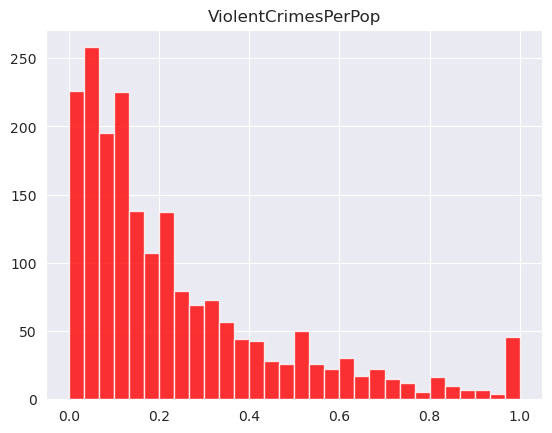

In [159]:
#histogram of violent crimes per pop
y.hist(column = ['ViolentCrimesPerPop'], bins = 30, color = 'red', alpha = 0.8)
plt.show()

In [160]:
df["highPctBlack"] = np.where(df['racepctblack'] < 0.05, 0.0, 1.0)
df["highCrimeRate"] = np.where(df['ViolentCrimesPerPop'] < 0.15, 0.0, 1.0)

# Examine Correlations
Analyze correlations between sensitive attributes (e.g. race, income) and target variables (e.g. crime rate)
Strong correlations might indicate proxy variables for sensitive attributes, potentially introducing bias 

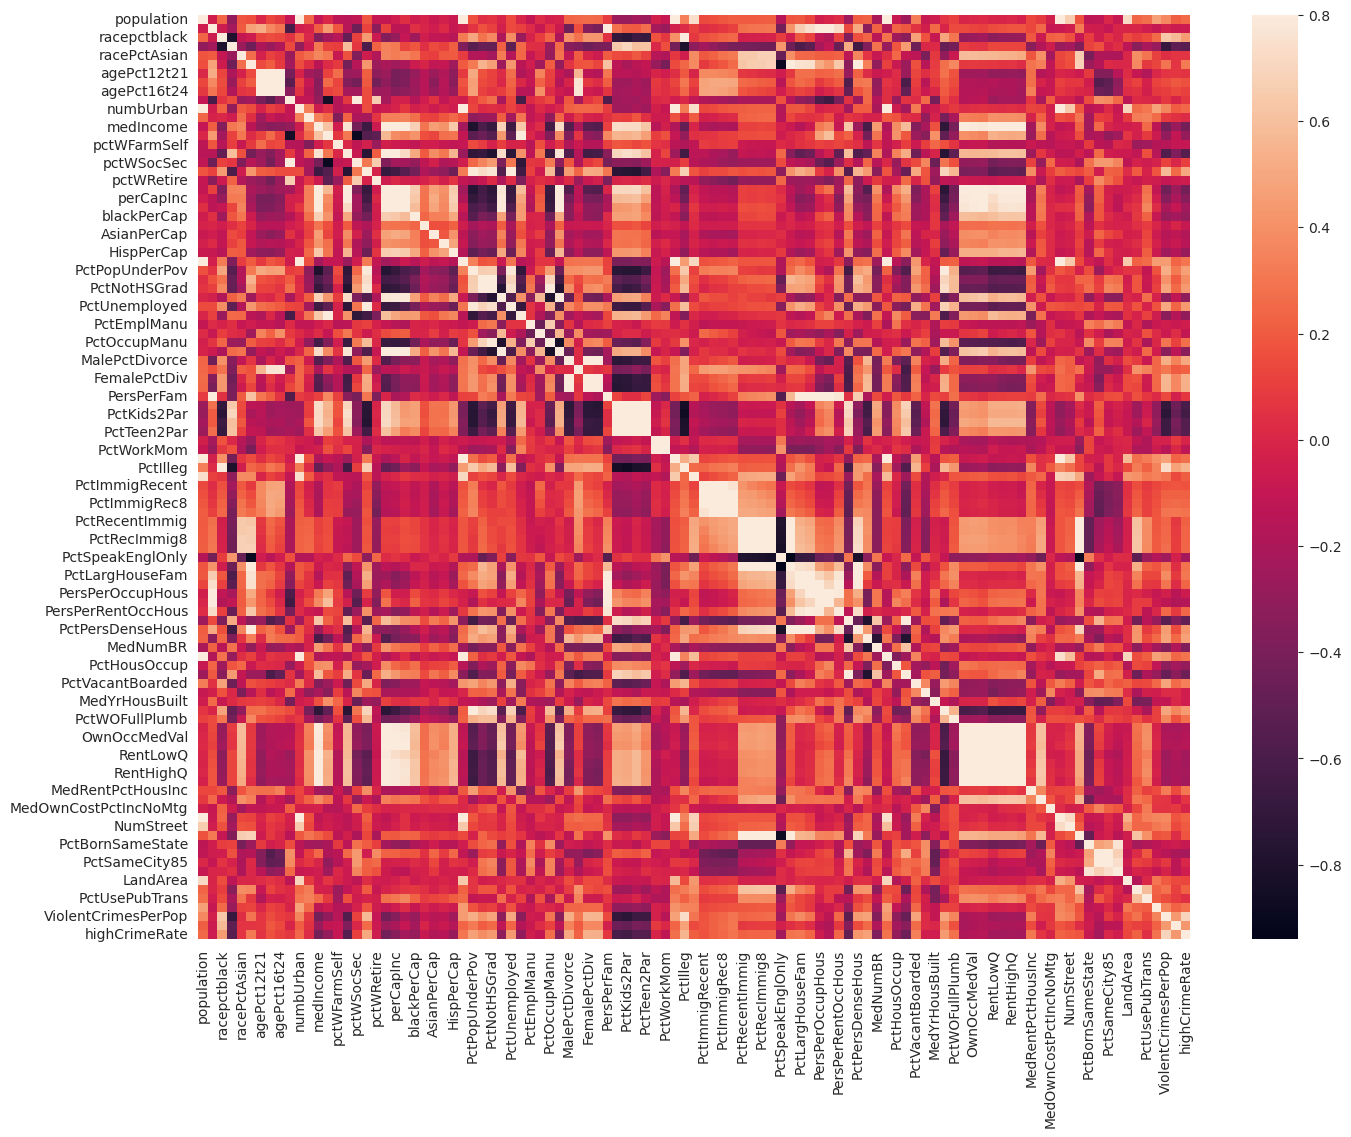

In [161]:
import seaborn as sns
corrmat = df.corr()
fig = plt.figure(figsize = (16, 12))

sns.heatmap(corrmat, vmax = 0.8)
plt.show()

In [163]:
corrT = df.corr(method = 'pearson').round(4)
corrT = corrT.sort_values(by=['highCrimeRate'])
corrT['highCrimeRate']

PctKids2Par           -0.6298
PctFam2Par            -0.6001
PctYoungKids2Par      -0.5534
pctWInvInc            -0.5487
PctTeen2Par           -0.5461
                        ...  
TotalPctDiv            0.5318
FemalePctDiv           0.5403
PctIlleg               0.5534
ViolentCrimesPerPop    0.6930
highCrimeRate          1.0000
Name: highCrimeRate, Length: 103, dtype: float64

In [190]:
new_df = df.drop(['ViolentCrimesPerPop'], axis=1)

In [191]:
def get_train_test_set(data, ratio=0.3, seed=0):
    from sklearn.model_selection import train_test_split
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]
    return train_test_split(X, y, test_size = ratio, random_state = seed)

In [278]:
X_train, X_test, y_train, y_test = get_train_test_set(new_df)

# Recursive 

In [279]:


from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
seed = 0
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=seed)

estimator = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42)
selector = RFECV(estimator, step=1, cv=cv, scoring = 'r2')
selector = selector.fit(X_train, y_train)

In [280]:

mask = selector.get_support()
print(len(mask))

101


In [281]:
X_train = X_train.loc[:, mask]
X_test = X_test.loc[:, mask]

In [282]:
X_test

,householdsize,racepctblack,racePctHisp,agePct65up,pctWInvInc,indianPerCap,NumUnderPov,PctEmplProfServ,MalePctDivorce,TotalPctDiv,...,PctWOFullPlumb,OwnOccMedVal,OwnOccHiQuart,RentLowQ,RentHighQ,MedRentPctHousInc,MedOwnCostPctIncNoMtg,NumStreet,LemasPctOfficDrugUn,highPctBlack
1805,0.31,0.02,0.05,0.54,0.54,0.00,0.02,0.53,0.41,0.44,...,0.06,0.05,0.06,0.14,0.18,0.42,0.39,0.0,0.0,0.0
1311,0.61,0.13,0.03,0.31,0.53,0.19,0.05,0.61,0.32,0.33,...,0.09,0.19,0.21,0.24,0.31,0.47,0.21,0.0,0.0,1.0
960,0.28,0.29,0.01,0.70,0.48,0.16,0.01,0.28,0.66,0.64,...,0.30,0.07,0.05,0.19,0.16,0.46,0.18,0.0,0.0,1.0
107,0.51,0.09,0.03,0.35,0.69,0.50,0.00,0.46,0.26,0.25,...,0.03,0.43,0.40,0.61,0.53,0.35,0.15,0.0,0.0,1.0
1557,0.51,0.14,0.18,0.32,0.59,0.32,0.01,0.38,0.46,0.51,...,0.09,0.50,0.49,0.71,0.76,0.59,0.14,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1431,0.56,0.09,0.87,0.31,0.35,0.01,0.02,0.26,0.49,0.51,...,0.57,0.06,0.07,0.13,0.18,0.69,0.21,0.0,0.0,1.0
2,0.42,0.49,0.04,0.32,0.39,0.07,0.01,0.29,0.63,0.70,...,0.45,0.17,0.16,0.27,0.27,0.48,0.28,0.0,0.0,1.0
1526,0.39,0.00,0.01,0.48,0.48,0.11,0.01,0.38,0.63,0.64,...,0.22,0.25,0.27,0.36,0.42,0.59,0.64,0.0,0.0,0.0
1696,0.42,0.03,0.03,0.39,0.64,0.39,0.00,0.41,0.39,0.38,...,0.11,0.51,0.52,0.65,0.83,0.47,0.56,0.0,0.0,0.0


# Pre-processing

In [300]:
from aif360.metrics import ClassificationMetric
from aif360.datasets import *

def evaluate_fairness(test, y_pred, unprivileged_groups, privileged_groups,
                      verbose=True, output_dict=False, convert_to_dataset=True, 
                      results_label=""):
    """
    Evaluates the fairness of a machine learning model's predictions.

    Parameters:
    - test (Dataset): The test dataset used for evaluation.
    - y_pred (array-like): The predicted labels for the test dataset.
    - unprivileged_groups (list of dicts): The unprivileged groups for fairness evaluation. e.g.,[{'Sex': 1}]
    - privileged_groups (list of dicts): The privileged groups for fairness evaluation.e.g., [{'Sex': 0}]
    - verbose (bool, optional): Whether to print the fairness metrics. Defaults to True.
    - output_dict (bool, optional): Whether to return the fairness metrics as a dictionary. Defaults to False.
    - convert_to_dataset (bool, optional): Whether to convert the test dataset to a new dataset with predictions. Defaults to True.
    - results_label (str, optional): A label for the fairness metrics. Defaults to "". Also used as value for "Label" key in results dict.

    Returns:
    - metrics_dict (dict, optional): A dictionary containing the fairness metrics if output_dict is True.

    """
    
    # Create a new dataset with predictions
    if convert_to_dataset:
        test = StandardDataset(test, label_name='highCrimeRate', favorable_classes=[1], protected_attribute_names=['highPctBlack'], privileged_classes=[[0]], instance_weights_name=None)
    test_pred = test.copy()
    test_pred.labels = y_pred

    # Evaluate fairness
    metric = ClassificationMetric(
        test,
        test_pred,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups
    )
    
    print(f"Fairness Metrics: {results_label}")
    metrics_dict = {
        "False negative rate ratio": metric.false_negative_rate_ratio(),
        "Disparate Impact": metric.disparate_impact(),
        "Statistical Parity Difference": metric.statistical_parity_difference(),
        "Equal Opportunity Difference": metric.equal_opportunity_difference(),
        "Average Odds Difference": metric.average_odds_difference(),
        "Accuracy": metric.accuracy()
    }
    
    if verbose:
        # Print metrics dict one by one
        for k, v in metrics_dict.items():
            print(f"- {k}: {v:.2f}")
        
    if output_dict:
        metrics_dict['Label'] = results_label
        return metrics_dict, metric

In [284]:
# X_test["highPctBlack"] = np.where(X_test['racepctblack'] < 0.3, 0.0, 1.0)
# X_train["highPctBlack"] = np.where(X_train['racepctblack'] < 0.3, 0.0, 1.0)

privileged_groups = [{'highPctBlack': 0}]
unprivileged_groups = [{'highPctBlack': 1}]

In [283]:
model = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear')

In [220]:
all_y = y.values.T[0]
midpoint = np.partition(all_y, int(len(all_y)/2))[int(len(all_y)/2)]
print(midpoint)
print()

0.15


In [286]:
import copy

X_test_with_label = copy.deepcopy(X_test)
X_test_with_label['highCrimeRate'] = y_test.values 
X_train_with_label = copy.deepcopy(X_train)
X_train_with_label['highCrimeRate'] = y_train.values 

In [287]:
X_test_with_label

,householdsize,racepctblack,racePctHisp,agePct65up,pctWInvInc,indianPerCap,NumUnderPov,PctEmplProfServ,MalePctDivorce,TotalPctDiv,...,OwnOccMedVal,OwnOccHiQuart,RentLowQ,RentHighQ,MedRentPctHousInc,MedOwnCostPctIncNoMtg,NumStreet,LemasPctOfficDrugUn,highPctBlack,highCrimeRate
1805,0.31,0.02,0.05,0.54,0.54,0.00,0.02,0.53,0.41,0.44,...,0.05,0.06,0.14,0.18,0.42,0.39,0.0,0.0,0.0,1.0
1311,0.61,0.13,0.03,0.31,0.53,0.19,0.05,0.61,0.32,0.33,...,0.19,0.21,0.24,0.31,0.47,0.21,0.0,0.0,1.0,0.0
960,0.28,0.29,0.01,0.70,0.48,0.16,0.01,0.28,0.66,0.64,...,0.07,0.05,0.19,0.16,0.46,0.18,0.0,0.0,1.0,1.0
107,0.51,0.09,0.03,0.35,0.69,0.50,0.00,0.46,0.26,0.25,...,0.43,0.40,0.61,0.53,0.35,0.15,0.0,0.0,1.0,0.0
1557,0.51,0.14,0.18,0.32,0.59,0.32,0.01,0.38,0.46,0.51,...,0.50,0.49,0.71,0.76,0.59,0.14,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1431,0.56,0.09,0.87,0.31,0.35,0.01,0.02,0.26,0.49,0.51,...,0.06,0.07,0.13,0.18,0.69,0.21,0.0,0.0,1.0,1.0
2,0.42,0.49,0.04,0.32,0.39,0.07,0.01,0.29,0.63,0.70,...,0.17,0.16,0.27,0.27,0.48,0.28,0.0,0.0,1.0,1.0
1526,0.39,0.00,0.01,0.48,0.48,0.11,0.01,0.38,0.63,0.64,...,0.25,0.27,0.36,0.42,0.59,0.64,0.0,0.0,0.0,1.0
1696,0.42,0.03,0.03,0.39,0.64,0.39,0.00,0.41,0.39,0.38,...,0.51,0.52,0.65,0.83,0.47,0.56,0.0,0.0,0.0,0.0


In [301]:
label = "Logistic Regression - Unmitigated"
y_pred = model.predict(X_test)

_, metrics = evaluate_fairness(X_test_with_label, y_pred, unprivileged_groups, privileged_groups, verbose=True, output_dict=True, results_label=label)

Fairness Metrics: Logistic Regression - Unmitigated
- False negative rate ratio: 1.12
- Disparate Impact: 1.96
- Statistical Parity Difference: 0.31
- Equal Opportunity Difference: -0.02
- Average Odds Difference: 0.04
- Accuracy: 0.81


/home/hocx3/miniconda3/envs/opacus-tml/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [291]:
from aif360.explainers import MetricTextExplainer
explainer = MetricTextExplainer(metrics)
explainer.disparate_impact()
# highCrimeRate=1 for high black > highCrimeRate=1 for low black  
# less than 1 indicates a bias toward predicting positive outcomes for the priviledged class (white)
# larger than 1 bias against predicting positive outcomes for the privileged class (while)

'Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 4.30656743700222'

In [295]:
print(explainer.statistical_parity_difference())
print(explainer.false_negative_rate_ratio())
print(explainer.accuracy())

Statistical parity difference (probability of favorable outcome for unprivileged instances - probability of favorable outcome for privileged instances): 0.571812413917677
False negative rate ratio (false negative rate on unprivileged instances / false negative rate on privileged instances): 0.24493243243243243
Classification accuracy (ACC): 0.8146911519198664


## Pre-processing 

In [296]:
from aif360.algorithms.preprocessing import Reweighing

In [297]:
RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
train = StandardDataset(X_train_with_label, label_name='highCrimeRate', favorable_classes=[1], protected_attribute_names=['highPctBlack'], privileged_classes=[[0]], instance_weights_name=None)
test = StandardDataset(X_test_with_label, label_name='highCrimeRate', favorable_classes=[1], protected_attribute_names=['highPctBlack'], privileged_classes=[[0]], instance_weights_name=None)
reweighed_train = RW.fit_transform(train)
reweighed_test = RW.transform(test)

In [298]:
display(train.instance_weights[:5])
reweighed_train.instance_weights[:5]

array([1., 1., 1., 1., 1.])

array([0.73148374, 0.73148374, 0.66435468, 1.66529698, 0.66435468])

In [302]:
# Extract features and labels from the reweighed dataset
wX_train = reweighed_train.features
wy_train = reweighed_train.labels.ravel()
# Extracting the reweighed sample weights
sample_weight = reweighed_train.instance_weights
wX_test = reweighed_test.features
wy_test = reweighed_test.labels.ravel()
# Train the model
label="Logistic Regression - Reweighed"
model =  LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42)
model.fit(wX_train, wy_train, sample_weight=sample_weight)
wy_pred = model.predict(wX_test)
eval_reweigh = evaluate_fairness(reweighed_test, wy_pred, unprivileged_groups, privileged_groups, results_label=label, output_dict=True, convert_to_dataset=False)

Fairness Metrics: Logistic Regression - Reweighed
- False negative rate ratio: 1.12
- Disparate Impact: 1.09
- Statistical Parity Difference: 0.05
- Equal Opportunity Difference: -0.02
- Average Odds Difference: 0.04
- Accuracy: 0.80


Based on the threshold for significant bias, Reweighed can mitigate the bias against privileged group

## Post-processing
Equalized Odds Post-Processing


In [303]:
from aif360.algorithms.postprocessing import EqOddsPostprocessing
# Apply Equalized Odds Post-Processing
eq_odds = EqOddsPostprocessing(
    privileged_groups=privileged_groups,
    unprivileged_groups=unprivileged_groups,
    seed=42
)


In [304]:
test_pred = test.copy()
test_pred.labels = y_pred.reshape(-1, 1)
eq_odds.fit(test, test_pred)
# Transform the predictions
# pred_transformed = eq_odds.transform(test_pred)
pred_transformed = eq_odds.predict(test_pred)

In [271]:

accuracy_score(test.labels, pred_transformed.labels)

0.6510851419031719

In [305]:
label = "Logistic Regression - EqOdds"
evaluate_fairness(test, pred_transformed.labels, unprivileged_groups, privileged_groups, output_dict=True, results_label=label, convert_to_dataset=False, verbose=0)

Fairness Metrics: Logistic Regression - EqOdds


({'False negative rate ratio': 0.9191176470588236,
  'Disparate Impact': 1.6051334353221147,
  'Statistical Parity Difference': 0.24114339903813592,
  'Equal Opportunity Difference': 0.018333333333333313,
  'Average Odds Difference': 0.007168130383381183,
  'Accuracy': 0.7696160267111853,
  'Label': 'Logistic Regression - EqOdds'},
 <aif360.metrics.classification_metric.ClassificationMetric at 0x7fec74412a20>)

The model fairness looks good with false negative rate ratio, but disparate impact and statistical parity difference still show bias against priviledged group. Accuracy decreases. 